In [360]:
"""
This Jupyter notebook walks through each part of the prepare_wine_data function to demonstrate each part of the process.
"""

'\nThis Jupyter notebook walks through each part of the prepare_wine_data function to demonstrate each part of the process.\n'

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import describe
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import stats


from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [6]:
def split_data(x_data, y_data, train_ratio, test_ratio, validate_ratio, seed=10):
    if train_ratio + test_ratio + validate_ratio != 1.00:
        raise ValueError("Ratios must add up to one")

    x_train, x_test_validate, y_train, y_test_validate = train_test_split(
        x_data, y_data, train_size=train_ratio, random_state=seed, stratify=y_data
    )
    x_test, x_validate, y_test, y_validate = train_test_split(
        x_test_validate,
        y_test_validate,
        train_size=test_ratio / (test_ratio + validate_ratio),
        random_state=seed,
        stratify=y_test_validate,
    )
    return (x_train, y_train), (x_test, y_test), (x_validate, y_validate)

In [29]:
"""
Method 1: gaussian quantiles
"""
x, y = make_gaussian_quantiles(cov=3.,
                               n_samples=10000, 
                               n_features=10,
                               n_classes=4, 
                               random_state=1)
y = to_categorical(y, num_classes=len(np.unique(y)))
train_data, test_data, validate_data = split_data(x, y, 0.7, 0.15, 0.15)

In [43]:
"""
Method 2: build classification task
"""
x,y = make_classification(n_samples=2000, 
                          n_features=10, 
                          n_informative=10,
                          n_redundant=0, 
                          n_repeated=0, 
                          n_classes=4, 
                          n_clusters_per_class=3,
                          class_sep=1.0,
                          flip_y=0.05,
                          random_state=17)
y = to_categorical(y, num_classes=len(np.unique(y)))
train_data, test_data, validate_data = split_data(x, y, 0.7, 0.15, 0.15)

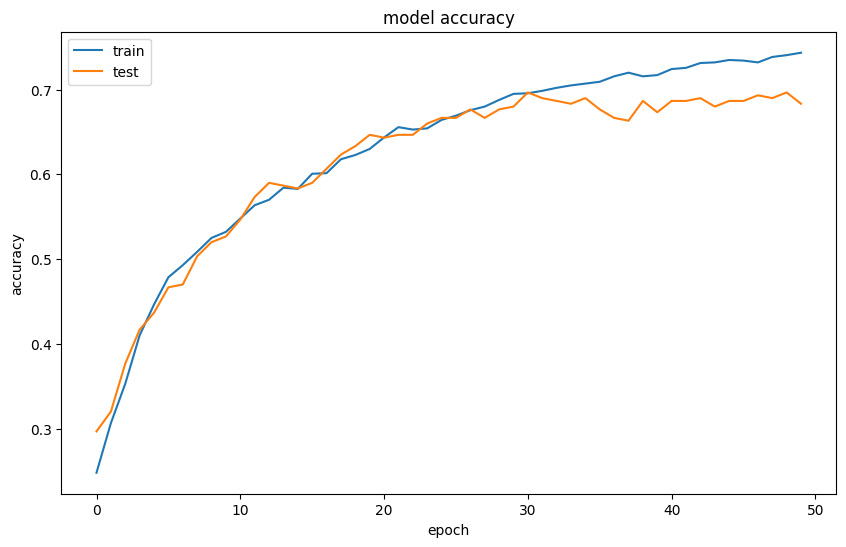

In [44]:
tf.keras.utils.set_random_seed(5)

class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        self.base_model = keras.models.Sequential(
            [
                layers.Dense(
                    20,
                    input_dim=10,
                    activation="relu",
                    bias_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                    kernel_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                ),
                layers.Dense(
                    10,
                    activation="relu",
                    bias_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                    kernel_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                ),
            ]
        )

        self.final_layer = layers.Dense(4, activation="softmax")

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.final_layer(x)
        return x


model = Net()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    *train_data, epochs=50, batch_size=36, verbose=0, validation_data=test_data
)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()